<a href="https://colab.research.google.com/github/debashisdotchatterjee/Time-Series-Statistical-Computational-Epidemiology/blob/main/time_series_epidemiology_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip -q install delphi-epidata statsmodels scipy pandas numpy matplotlib epiweeks tqdm


In [3]:
%%writefile companion_epitime_pipeline.py
# ============================================================
# Companion Script (Paper-Grade, Colab-Friendly)
# Time-Series Statistical Computational Epidemiology
#   - REAL data: ILINet FluView (wILI/ILI) via CMU Delphi Epidata API (delphi-epidata)
#   - Model: SARIMAX (candidate selection by AIC/BIC) + probabilistic forecasting
#   - Evaluation: rolling-origin (multi-horizon), log score, WIS, coverage/width, PIT
#   - Monitoring: anytime-valid e-process on standardized 1-step predictive residuals
#   - Outputs: MANY figures + MANY tables saved, also shown inline, and zipped
#
# Data source docs:
#   FluView endpoint (wili/ili, geos, epiweeks): https://cmu-delphi.github.io/delphi-epidata/api/fluview.html
#   Epidata API main: https://cmu-delphi.github.io/delphi-epidata/api/
#
# Notes:
#   - Use %run (NOT !python) to see plots/tables inline in Colab.
#   - The script still saves everything to disk and creates a ZIP bundle.
# ============================================================

import os, sys, json, math, platform, textwrap, zipfile
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL

from tqdm.auto import tqdm

# Optional: exact CDC epiweek date mapping (preferred)
try:
    from epiweeks import Week
    _HAS_EPIWEEKS = True
except Exception:
    _HAS_EPIWEEKS = False


# ----------------------------
# Colab / IPython helpers
# ----------------------------
def in_ipython():
    try:
        from IPython import get_ipython
        return get_ipython() is not None
    except Exception:
        return False

def in_colab():
    return "google.colab" in sys.modules

def safe_display(df, title=None, max_rows=30):
    """Show a DataFrame nicely in notebook, and also print a copy-ready text version."""
    if title:
        print("\n" + "="*len(title))
        print(title)
        print("="*len(title))
    try:
        from IPython.display import display
        display(df.head(max_rows) if isinstance(df, pd.DataFrame) else df)
    except Exception:
        pass
    if isinstance(df, pd.DataFrame):
        with pd.option_context("display.max_rows", max_rows, "display.max_columns", 200, "display.width", 200):
            print(df.head(max_rows).to_string())

def stamp():
    return datetime.now().strftime("%Y%m%d_%H%M%S")

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def save_fig(path: Path):
    plt.tight_layout()
    plt.savefig(path, dpi=240, bbox_inches="tight")
    try:
        plt.savefig(path.with_suffix(".pdf"), bbox_inches="tight")
    except Exception:
        pass


# ----------------------------
# Epiweek -> date
# ----------------------------
def epiweek_to_date(epiweek: int):
    """Prefer epiweeks.Week for accurate MMWR-like weeks; fallback to ISO week Monday."""
    year = int(epiweek // 100)
    week = int(epiweek % 100)
    week = max(1, min(53, week))
    if _HAS_EPIWEEKS:
        return Week(year, week).startdate()
    # fallback: ISO-week Monday (approx)
    from datetime import date
    return date.fromisocalendar(year, week, 1)


# ----------------------------
# Data acquisition (REAL)
# ----------------------------
def fetch_fluview(ew_start: int, ew_end: int, geo: str, signal: str):
    """
    Fetch FluView via delphi-epidata.
    signal in {"wili","ili"}.
    """
    from delphi_epidata import Epidata
    resp = Epidata.fluview(geo, Epidata.range(ew_start, ew_end))
    if resp.get("result", 0) != 1:
        raise RuntimeError(f"Delphi API error: {resp}")
    df = pd.DataFrame(resp["epidata"]).sort_values("epiweek").reset_index(drop=True)
    if signal not in df.columns:
        raise ValueError(f"Requested signal='{signal}' not found. Available columns: {df.columns.tolist()}")
    df = df[["epiweek", signal]].rename(columns={signal: "y_raw"})
    df["y_raw"] = pd.to_numeric(df["y_raw"], errors="coerce")
    return df

def build_weekly_index(df: pd.DataFrame):
    """Return weekly time-indexed df with continuous weekly grid."""
    d = df.copy()
    d["date"] = d["epiweek"].apply(epiweek_to_date)
    d = d.sort_values("date").reset_index(drop=True)
    idx = pd.date_range(pd.to_datetime(d["date"].min()), pd.to_datetime(d["date"].max()), freq="W-SUN")
    # Using W-SUN matches typical epiweek reporting alignment better for plotting.
    out = d.set_index(pd.to_datetime(d["date"]))[["y_raw"]].reindex(idx)
    out.index.name = "date"
    out = out.rename(columns={"y_raw": "y"})
    return out


# ----------------------------
# Output paths
# ----------------------------
@dataclass
class OutPaths:
    root: Path
    figs: Path
    tables: Path
    cache: Path
    zip_path: Path

def make_outpaths(base: Path):
    run_name = f"epitime_run_{stamp()}"
    root = base / run_name
    figs = root / "figs"
    tables = root / "tables"
    cache = root / "cache"
    ensure_dir(figs); ensure_dir(tables); ensure_dir(cache)
    zip_path = base / f"{run_name}.zip"
    return OutPaths(root=root, figs=figs, tables=tables, cache=cache, zip_path=zip_path)


# ----------------------------
# Save tables
# ----------------------------
def save_table(df: pd.DataFrame, paths: OutPaths, name: str, latex=True):
    csv_path = paths.tables / f"{name}.csv"
    df.to_csv(csv_path, index=True)
    if latex:
        try:
            tex_path = paths.tables / f"{name}.tex"
            tex_path.write_text(df.to_latex(index=True, escape=False), encoding="utf-8")
        except Exception:
            pass


# ----------------------------
# EDA plots (MANY)
# ----------------------------
def eda_plots(dfw: pd.DataFrame, paths: OutPaths, period=52):
    y = dfw["y"]

    # 01 series
    plt.figure(figsize=(13,3.6))
    plt.plot(y.index, y.values)
    plt.title("Weekly influenza-like illness (wILI/ILI) time series")
    plt.xlabel("Week"); plt.ylabel("Value (%)")
    save_fig(paths.figs / "01_series.png"); plt.show()

    # 02 rolling mean/std
    win = 13
    plt.figure(figsize=(13,3.6))
    plt.plot(y.index, y.values, label="y", alpha=0.75)
    plt.plot(y.index, y.rolling(win, min_periods=1).mean(), label=f"rolling mean ({win})")
    plt.plot(y.index, y.rolling(win, min_periods=1).std(), label=f"rolling sd ({win})")
    plt.legend()
    plt.title("Rolling mean and volatility")
    plt.xlabel("Week"); plt.ylabel("Value (%)")
    save_fig(paths.figs / "02_rolling_mean_sd.png"); plt.show()

    # 03 rolling quantiles
    plt.figure(figsize=(13,3.6))
    q10 = y.rolling(win, min_periods=1).quantile(0.10)
    q50 = y.rolling(win, min_periods=1).quantile(0.50)
    q90 = y.rolling(win, min_periods=1).quantile(0.90)
    plt.plot(y.index, y.values, alpha=0.45, label="y")
    plt.plot(y.index, q50, label="rolling median")
    plt.plot(y.index, q10, label="rolling q10")
    plt.plot(y.index, q90, label="rolling q90")
    plt.legend()
    plt.title("Rolling quantiles")
    plt.xlabel("Week"); plt.ylabel("Value (%)")
    save_fig(paths.figs / "03_rolling_quantiles.png"); plt.show()

    # 04 histogram
    plt.figure(figsize=(10,3.4))
    plt.hist(y.dropna().values, bins=35)
    plt.title("Histogram"); plt.xlabel("Value (%)"); plt.ylabel("Count")
    save_fig(paths.figs / "04_hist.png"); plt.show()

    # 05 ECDF
    v = np.sort(y.dropna().values)
    ecdf = np.arange(1, len(v)+1)/len(v)
    plt.figure(figsize=(10,3.4))
    plt.step(v, ecdf, where="post")
    plt.title("Empirical CDF"); plt.xlabel("Value (%)"); plt.ylabel("ECDF")
    save_fig(paths.figs / "05_ecdf.png"); plt.show()

    # 06 QQ vs Normal
    plt.figure(figsize=(6.2,6.0))
    sm.qqplot(y.dropna().values, line="45", fit=True)
    plt.title("QQ plot vs Normal")
    save_fig(paths.figs / "06_qq_y.png"); plt.show()

    # 07 year-week heatmap
    tmp = dfw.copy()
    tmp["year"] = tmp.index.year
    tmp["week"] = tmp.index.isocalendar().week.astype(int)
    piv = tmp.pivot_table(index="year", columns="week", values="y", aggfunc="mean")
    plt.figure(figsize=(13,4.4))
    plt.imshow(piv.values, aspect="auto", interpolation="nearest")
    plt.colorbar(label="Value (%)")
    plt.yticks(range(len(piv.index)), piv.index)
    plt.xticks([0,13,26,39,51], ["1","14","27","40","52"])
    plt.title("Year–week heatmap")
    plt.xlabel("Week"); plt.ylabel("Year")
    save_fig(paths.figs / "07_heatmap.png"); plt.show()

    # 08 seasonal subseries
    years = sorted(tmp["year"].dropna().unique().tolist())
    plt.figure(figsize=(13,4.4))
    for yr in years:
        block = tmp[tmp["year"]==yr].sort_values("week")
        plt.plot(block["week"].values, block["y"].values, alpha=0.7)
    plt.title("Seasonal subseries (each year over weeks)")
    plt.xlabel("Week"); plt.ylabel("Value (%)")
    save_fig(paths.figs / "08_seasonal_subseries.png"); plt.show()

    # 09 STL decomposition
    yf = y.interpolate(limit_direction="both")
    stl = STL(yf, period=period, robust=True).fit()

    plt.figure(figsize=(13,7.8))
    plt.subplot(4,1,1); plt.plot(yf.index, yf.values); plt.title("STL (robust)"); plt.ylabel("Observed")
    plt.subplot(4,1,2); plt.plot(stl.trend.index, stl.trend.values); plt.ylabel("Trend")
    plt.subplot(4,1,3); plt.plot(stl.seasonal.index, stl.seasonal.values); plt.ylabel("Seasonal")
    plt.subplot(4,1,4); plt.plot(stl.resid.index, stl.resid.values); plt.ylabel("Remainder"); plt.xlabel("Week")
    save_fig(paths.figs / "09_stl.png"); plt.show()

    # 10 ACF/PACF
    plt.figure(figsize=(13,4.0))
    ax1 = plt.subplot(1,2,1); plot_acf(yf, lags=2*period, ax=ax1); ax1.set_title("ACF (up to 2 years)")
    ax2 = plt.subplot(1,2,2); plot_pacf(yf, lags=60, ax=ax2, method="ywm"); ax2.set_title("PACF (up to 60)")
    save_fig(paths.figs / "10_acf_pacf.png"); plt.show()

    # 11 differences
    plt.figure(figsize=(13,3.2))
    plt.plot(yf.diff().index, yf.diff().values)
    plt.title("First difference"); plt.xlabel("Week"); plt.ylabel("Δy")
    save_fig(paths.figs / "11_diff1.png"); plt.show()

    plt.figure(figsize=(13,3.2))
    plt.plot(yf.diff(period).index, yf.diff(period).values)
    plt.title(f"Seasonal difference (lag={period})"); plt.xlabel("Week"); plt.ylabel("Δ_s y")
    save_fig(paths.figs / "12_diff_seasonal.png"); plt.show()


# ----------------------------
# Tables: summaries + stationarity
# ----------------------------
def make_summary_tables(dfw: pd.DataFrame, paths: OutPaths):
    y = dfw["y"]

    summary = pd.DataFrame({
        "n_weeks": [len(dfw)],
        "n_missing": [int(y.isna().sum())],
        "missing_rate": [float(y.isna().mean())],
        "min": [float(np.nanmin(y.values))],
        "p25": [float(np.nanpercentile(y.values, 25))],
        "median": [float(np.nanmedian(y.values))],
        "mean": [float(np.nanmean(y.values))],
        "p75": [float(np.nanpercentile(y.values, 75))],
        "max": [float(np.nanmax(y.values))],
        "sd": [float(np.nanstd(y.values, ddof=1))],
    }, index=["summary"])

    # Top peaks
    top = dfw.dropna().sort_values("y", ascending=False).head(20)
    bottom = dfw.dropna().sort_values("y", ascending=True).head(20)

    # Stationarity tests (on interpolated)
    yf = y.interpolate(limit_direction="both").dropna()
    adf = adfuller(yf, autolag="AIC")
    try:
        kps = kpss(yf, regression="c", nlags="auto")
    except Exception:
        kps = (np.nan, np.nan, np.nan, {})

    stest = pd.DataFrame({
        "statistic": [adf[0], kps[0]],
        "p_value": [adf[1], kps[1]],
        "notes": [
            "ADF H0: unit root (non-stationary); small p rejects",
            "KPSS H0: level-stationary; small p rejects",
        ]
    }, index=["ADF", "KPSS(level)"])

    save_table(summary, paths, "T01_data_summary")
    save_table(top, paths, "T02_top_weeks")
    save_table(bottom, paths, "T03_bottom_weeks")
    save_table(stest, paths, "T04_stationarity_tests")

    safe_display(summary, "TABLE: Data summary")
    safe_display(stest, "TABLE: Stationarity tests (ADF, KPSS)")
    safe_display(top, "TABLE: Top 20 peak weeks")
    return summary, stest, top


# ----------------------------
# Candidate SARIMAX search (paper-worthy but controlled)
# ----------------------------
def sarimax_candidates(period=52, grid="paper"):
    """
    A moderate but paper-appropriate candidate set.
    Keeps runtime sane while allowing meaningful selection.
    """
    cand = []
    # Nonseasonal
    p_list = [0,1,2]
    d_list = [0,1]
    q_list = [0,1,2]
    # Seasonal (keep small, typical for weekly flu)
    P_list = [0,1]
    D_list = [1]      # seasonal differencing is usually needed
    Q_list = [0,1]

    # reduce grid if requested
    if grid == "small":
        p_list = [0,1,2]; d_list=[0,1]; q_list=[0,1]
        P_list=[0,1]; D_list=[1]; Q_list=[0,1]
    elif grid == "paper":
        pass
    else:
        # larger
        p_list=[0,1,2,3]; d_list=[0,1]; q_list=[0,1,2,3]
        P_list=[0,1,2]; D_list=[1]; Q_list=[0,1,2]

    for p in p_list:
        for d in d_list:
            for q in q_list:
                for P in P_list:
                    for D in D_list:
                        for Q in Q_list:
                            cand.append(((p,d,q), (P,D,Q,period)))
    return cand


def fit_sarimax(y_train: pd.Series, order, seas, trend="c", maxiter=200):
    model = SARIMAX(
        y_train,
        order=order,
        seasonal_order=seas,
        trend=trend,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False, maxiter=maxiter, method="lbfgs")
    return res


def select_sarimax(y_train: pd.Series, period=52, grid="paper", maxiter=200):
    rows = []
    cand = sarimax_candidates(period=period, grid=grid)

    for (order, seas) in tqdm(cand, desc="SARIMAX candidate fits"):
        try:
            res = fit_sarimax(y_train, order, seas, trend="c", maxiter=maxiter)
            rows.append({
                "order": str(order),
                "seasonal_order": str(seas),
                "AIC": float(res.aic),
                "BIC": float(res.bic),
                "HQIC": float(res.hqic),
                "converged": bool(getattr(res, "mle_retvals", {}).get("converged", True))
            })
        except Exception:
            rows.append({
                "order": str(order),
                "seasonal_order": str(seas),
                "AIC": np.nan, "BIC": np.nan, "HQIC": np.nan, "converged": False
            })

    tab = pd.DataFrame(rows).sort_values(["AIC","BIC"], na_position="last").reset_index(drop=True)
    best = tab.dropna().iloc[0] if tab["AIC"].notna().any() else None
    return best, tab


def plot_model_selection(aic_table: pd.DataFrame, paths: OutPaths):
    t = aic_table.dropna().copy()
    # 13 AIC ranked plot
    plt.figure(figsize=(11,3.4))
    plt.plot(np.arange(len(t)), t["AIC"].values)
    plt.title("Candidate SARIMAX AIC (sorted)")
    plt.xlabel("Candidate rank"); plt.ylabel("AIC")
    save_fig(paths.figs / "13_aic_sorted.png"); plt.show()

    # 14 AIC vs BIC scatter
    plt.figure(figsize=(6.2,6.0))
    plt.scatter(t["AIC"].values, t["BIC"].values, s=16, alpha=0.7)
    plt.title("Candidate tradeoff: AIC vs BIC")
    plt.xlabel("AIC"); plt.ylabel("BIC")
    save_fig(paths.figs / "14_aic_bic_scatter.png"); plt.show()


# ----------------------------
# Diagnostics
# ----------------------------
def residual_diagnostics(res, paths: OutPaths, prefix="D"):
    resid = pd.Series(res.resid).dropna()
    # 15 residual time series
    plt.figure(figsize=(13,3.2))
    plt.plot(resid.index, resid.values)
    plt.axhline(0.0, linestyle="--")
    plt.title("Model residuals over time")
    plt.xlabel("Time"); plt.ylabel("Residual")
    save_fig(paths.figs / f"{prefix}15_resid_ts.png"); plt.show()

    # 16 resid hist
    plt.figure(figsize=(10,3.2))
    plt.hist(resid.values, bins=35)
    plt.title("Residual histogram"); plt.xlabel("Residual"); plt.ylabel("Count")
    save_fig(paths.figs / f"{prefix}16_resid_hist.png"); plt.show()

    # 17 QQ
    plt.figure(figsize=(6.2,6.0))
    sm.qqplot(resid.values, line="45", fit=True)
    plt.title("Residual QQ plot")
    save_fig(paths.figs / f"{prefix}17_resid_qq.png"); plt.show()

    # 18 ACF
    plt.figure(figsize=(10,3.2))
    plot_acf(resid.values, lags=min(60, len(resid)-1), ax=plt.gca())
    plt.title("Residual ACF")
    save_fig(paths.figs / f"{prefix}18_resid_acf.png"); plt.show()

    # tests table
    jb = stats.jarque_bera(resid.values)
    lb = sm.stats.acorr_ljungbox(resid.values, lags=[10,20,30], return_df=True)

    tests = pd.DataFrame({
        "JarqueBera_stat": [float(jb.statistic)],
        "JarqueBera_p": [float(jb.pvalue)],
        "LjungBox_p_lag10": [float(lb["lb_pvalue"].iloc[0])],
        "LjungBox_p_lag20": [float(lb["lb_pvalue"].iloc[1])],
        "LjungBox_p_lag30": [float(lb["lb_pvalue"].iloc[2])]
    }, index=["tests"])

    save_table(tests, paths, f"T07_residual_tests_{prefix}")
    safe_display(tests, "TABLE: Residual diagnostics tests (JB, Ljung-Box)")
    return tests


# ----------------------------
# Rolling-origin evaluation (multi-horizon, periodic refit)
# ----------------------------
def normal_logscore(y, m, s):
    s = np.maximum(s, 1e-8)
    return -stats.norm(loc=m, scale=s).logpdf(y)

def interval_metrics(y, m, s, levels=(0.5,0.8,0.95)):
    out = []
    for lev in levels:
        a = 1-lev
        lo = stats.norm.ppf(a/2, loc=m, scale=s)
        hi = stats.norm.ppf(1-a/2, loc=m, scale=s)
        out.append({
            "level": lev,
            "coverage": float(np.mean((y>=lo)&(y<=hi))),
            "avg_width": float(np.mean(hi-lo))
        })
    return pd.DataFrame(out).set_index("level")

def weighted_interval_score(y, m, s, levels=(0.5,0.8,0.95)):
    """
    Simple WIS using Normal predictive intervals (approx):
      WIS = sum_k w_k * IS_{alpha_k}  where alpha_k = 1 - level_k
    """
    K = len(levels)
    weights = [0.5] + [1.0]*K  # includes median term weight 0.5 (common convention)
    # median absolute error term
    wis = weights[0] * np.mean(np.abs(y - m))
    for lev in levels:
        alpha = 1-lev
        lo = stats.norm.ppf(alpha/2, loc=m, scale=s)
        hi = stats.norm.ppf(1-alpha/2, loc=m, scale=s)
        # interval score
        iscore = (hi-lo) + (2/alpha)*(lo-y)*(y<lo) + (2/alpha)*(y-hi)*(y>hi)
        wis += np.mean(iscore)
    return float(wis)

def compute_pit(y, m, s):
    s = np.maximum(s, 1e-8)
    return stats.norm(loc=m, scale=s).cdf(y)

def rolling_origin(
    y: pd.Series,
    order, seas,
    horizons=(1,2,4,8),
    train_frac=0.70,
    refit_every=13,
    maxiter=200
):
    y = y.dropna()
    n = len(y)
    n0 = int(math.floor(train_frac*n))
    idx = y.index

    # storage
    store = {h: {"date": [], "y": [], "m": [], "s": []} for h in horizons}

    res = None
    last_refit = None

    for t0 in tqdm(range(n0, n-max(horizons)), desc="Rolling-origin evaluation"):
        if (res is None) or (last_refit is None) or ((t0-last_refit) >= refit_every):
            res = fit_sarimax(y.iloc[:t0], order, seas, trend="c", maxiter=maxiter)
            last_refit = t0

        for h in horizons:
            target_date = idx[t0+h]
            y_true = float(y.iloc[t0+h])
            fc = res.get_forecast(steps=h)
            m = float(fc.predicted_mean.iloc[-1])

            # variance
            if hasattr(fc, "var_pred_mean"):
                v = float(fc.var_pred_mean.iloc[-1])
                s = math.sqrt(max(v, 1e-10))
            else:
                s = float(fc.se_mean.iloc[-1])
                s = max(s, 1e-6)

            store[h]["date"].append(target_date)
            store[h]["y"].append(y_true)
            store[h]["m"].append(m)
            store[h]["s"].append(s)

    # assemble tables + metrics
    detail = {}
    rows = []
    for h in horizons:
        dfh = pd.DataFrame(store[h]).set_index("date")
        dfh["err"] = dfh["y"] - dfh["m"]
        detail[h] = dfh

        mae = float(np.mean(np.abs(dfh["err"])))
        rmse = float(np.sqrt(np.mean(dfh["err"]**2)))
        mape = float(np.mean(np.abs(dfh["err"]) / np.maximum(dfh["y"], 1e-8)) * 100.0)
        ls = float(np.mean(normal_logscore(dfh["y"].values, dfh["m"].values, dfh["s"].values)))
        pit = compute_pit(dfh["y"].values, dfh["m"].values, dfh["s"].values)
        wis = weighted_interval_score(dfh["y"].values, dfh["m"].values, dfh["s"].values)

        cov = interval_metrics(dfh["y"].values, dfh["m"].values, dfh["s"].values)

        rows.append({
            "h": h,
            "N": len(dfh),
            "MAE": mae,
            "RMSE": rmse,
            "MAPE(%)": mape,
            "MeanLogScore": ls,
            "WIS": wis,
            "Cov50": float(cov.loc[0.5, "coverage"]),
            "Cov80": float(cov.loc[0.8, "coverage"]),
            "Cov95": float(cov.loc[0.95, "coverage"]),
            "Width95": float(cov.loc[0.95, "avg_width"])
        })

    metrics = pd.DataFrame(rows).set_index("h")
    return detail, metrics


def plot_forecast_panels(detail: dict, paths: OutPaths):
    # 19 rolling forecasts per horizon
    for h, dfh in detail.items():
        lo = dfh["m"] + stats.norm.ppf(0.025)*dfh["s"]
        hi = dfh["m"] + stats.norm.ppf(0.975)*dfh["s"]

        plt.figure(figsize=(13,3.8))
        plt.plot(dfh.index, dfh["y"].values, label="true")
        plt.plot(dfh.index, dfh["m"].values, label=f"pred mean (h={h})")
        plt.fill_between(dfh.index, lo.values, hi.values, alpha=0.25, label="95% PI")
        plt.legend()
        plt.title(f"Rolling-origin forecasts (h={h})")
        plt.xlabel("Week"); plt.ylabel("Value (%)")
        save_fig(paths.figs / f"19_forecast_h{h}.png"); plt.show()

        # PIT histogram per horizon
        pit = compute_pit(dfh["y"].values, dfh["m"].values, dfh["s"].values)
        plt.figure(figsize=(10,3.2))
        plt.hist(pit, bins=20)
        plt.title(f"PIT histogram (h={h})")
        plt.xlabel("PIT"); plt.ylabel("Count")
        save_fig(paths.figs / f"20_pit_h{h}.png"); plt.show()


def plot_metric_curves(metrics: pd.DataFrame, paths: OutPaths):
    # 21 errors vs horizon
    hs = metrics.index.values
    plt.figure(figsize=(10,3.2))
    plt.plot(hs, metrics["MAE"].values, marker="o", label="MAE")
    plt.plot(hs, metrics["RMSE"].values, marker="o", label="RMSE")
    plt.title("Forecast error vs horizon")
    plt.xlabel("Horizon (weeks)"); plt.ylabel("Error")
    plt.legend()
    save_fig(paths.figs / "21_error_vs_h.png"); plt.show()

    # 22 calibration/coverage vs horizon
    plt.figure(figsize=(10,3.2))
    plt.plot(hs, metrics["Cov50"].values, marker="o", label="50%")
    plt.plot(hs, metrics["Cov80"].values, marker="o", label="80%")
    plt.plot(hs, metrics["Cov95"].values, marker="o", label="95%")
    plt.axhline(0.5, linestyle="--"); plt.axhline(0.8, linestyle="--"); plt.axhline(0.95, linestyle="--")
    plt.title("Empirical PI coverage vs horizon")
    plt.xlabel("Horizon (weeks)"); plt.ylabel("Coverage")
    plt.legend()
    save_fig(paths.figs / "22_coverage_vs_h.png"); plt.show()

    # 23 proper scoring rules vs horizon
    plt.figure(figsize=(10,3.2))
    plt.plot(hs, metrics["MeanLogScore"].values, marker="o", label="Mean log score")
    plt.plot(hs, metrics["WIS"].values, marker="o", label="WIS")
    plt.title("Proper scoring rules vs horizon (lower is better)")
    plt.xlabel("Horizon (weeks)"); plt.ylabel("Score")
    plt.legend()
    save_fig(paths.figs / "23_scores_vs_h.png"); plt.show()


# ----------------------------
# Online 1-step predictions + e-process monitoring (anytime-valid)
# ----------------------------
def eprocess_from_z(z: np.ndarray, lambdas=(0.25,0.5,0.75,1.0,1.25), alpha=0.05):
    z = np.asarray(z, dtype=float)
    lambdas = np.asarray(lambdas, dtype=float)
    e_parts = np.exp(np.outer(lambdas, z) - 0.5*(lambdas**2)[:,None])
    e = e_parts.mean(axis=0)
    logM = np.cumsum(np.log(np.maximum(e, 1e-12)))
    M = np.exp(logM)
    thr = 1.0/alpha
    alarm = (M >= thr)
    first = int(np.argmax(alarm)) if alarm.any() else None
    return e, M, thr, first

def online_one_step_monitor(
    y: pd.Series,
    order, seas,
    train_frac=0.70,
    refit_every=13,
    maxiter=200,
    alpha=0.05
):
    """
    Truthful online-style monitoring:
      - fit parameters on initial window
      - sequentially produce 1-step predictive mean/var
      - extend the state with the new observation
      - optionally refit parameters every refit_every steps
    """
    y = y.dropna()
    n = len(y)
    n0 = int(math.floor(train_frac*n))
    idx = y.index

    # initial fit
    res = fit_sarimax(y.iloc[:n0], order, seas, trend="c", maxiter=maxiter)

    dates = []
    y_true = []
    m = []
    s = []

    last_refit_at = n0

    for t in tqdm(range(n0, n-1), desc="Online 1-step predictions"):
        # forecast next
        fc = res.get_forecast(steps=1)
        mean_next = float(fc.predicted_mean.iloc[0])
        if hasattr(fc, "var_pred_mean"):
            var_next = float(fc.var_pred_mean.iloc[0])
            sd_next = math.sqrt(max(var_next, 1e-10))
        else:
            sd_next = max(float(fc.se_mean.iloc[0]), 1e-6)

        obs_next = float(y.iloc[t+1])
        dates.append(idx[t+1])
        y_true.append(obs_next)
        m.append(mean_next)
        s.append(sd_next)

        # update state without refitting parameters
        res = res.extend(endog=[obs_next], refit=False)

        # periodic refit (parameters) for adaptivity
        if (t+1 - last_refit_at) >= refit_every:
            res = fit_sarimax(y.iloc[:t+2], order, seas, trend="c", maxiter=maxiter)
            last_refit_at = t+1

    df = pd.DataFrame({"y": y_true, "mean1": m, "sd1": s}, index=pd.to_datetime(dates))
    df["z"] = (df["y"] - df["mean1"]) / np.maximum(df["sd1"], 1e-8)

    e, M, thr, first = eprocess_from_z(df["z"].values, alpha=alpha)
    df["e"] = e
    df["M"] = M

    meta = {"alpha": alpha, "threshold": thr, "first_alarm_date": (df.index[first] if first is not None else None)}
    return df, meta

def plot_monitor(dfm: pd.DataFrame, meta: dict, paths: OutPaths):
    thr = meta["threshold"]
    fa = meta["first_alarm_date"]

    # 24 e-process
    plt.figure(figsize=(13,3.4))
    plt.plot(dfm.index, dfm["M"].values)
    plt.axhline(thr, linestyle="--")
    if fa is not None:
        plt.axvline(pd.to_datetime(fa), linestyle=":")
    plt.title(f"E-process monitoring (threshold=1/alpha={thr:.1f})")
    plt.xlabel("Week"); plt.ylabel("M_t")
    save_fig(paths.figs / "24_eprocess_M.png"); plt.show()

    # 25 z_t
    plt.figure(figsize=(13,3.0))
    plt.plot(dfm.index, dfm["z"].values)
    plt.axhline(0.0, linestyle="--")
    plt.title("Standardized 1-step predictive residuals z_t")
    plt.xlabel("Week"); plt.ylabel("z_t")
    save_fig(paths.figs / "25_z_series.png"); plt.show()

    # 26 observed vs mean1 (monitor window)
    lo = dfm["mean1"] + stats.norm.ppf(0.025)*dfm["sd1"]
    hi = dfm["mean1"] + stats.norm.ppf(0.975)*dfm["sd1"]
    plt.figure(figsize=(13,3.8))
    plt.plot(dfm.index, dfm["y"].values, label="y")
    plt.plot(dfm.index, dfm["mean1"].values, label="mean1")
    plt.fill_between(dfm.index, lo.values, hi.values, alpha=0.25, label="95% PI")
    plt.legend()
    plt.title("Online 1-step predictive fit (monitoring window)")
    plt.xlabel("Week"); plt.ylabel("Value (%)")
    save_fig(paths.figs / "26_monitor_fit.png"); plt.show()


# ----------------------------
# BibTeX writer (truthful, from official sources where possible)
# ----------------------------
BIBTEX = r"""
@inproceedings{seabold2010statsmodels,
  title={statsmodels: Econometric and statistical modeling with python},
  author={Seabold, Skipper and Perktold, Josef},
  booktitle={Proceedings of the 9th Python in Science Conference},
  year={2010}
}

@article{page1954cusum,
  title={Continuous inspection schemes},
  author={Page, E. S.},
  journal={Biometrika},
  volume={41},
  number={1/2},
  pages={100--115},
  year={1954}
}

@article{howard2021confseq,
  title={Time-uniform, nonparametric, nonasymptotic confidence sequences},
  author={Howard, Steven R. and Ramdas, Aaditya and McAuliffe, Jon and Sekhon, Jasjeet},
  journal={The Annals of Statistics},
  volume={49},
  number={2},
  pages={1055--1080},
  year={2021},
  doi={10.1214/20-AOS1991}
}

@misc{delphiEpidataAPI,
  title={Delphi Epidata API Documentation},
  author={{CMU Delphi Research Group}},
  howpublished={Online},
  note={Accessed 2026-02-12},
  url={https://cmu-delphi.github.io/delphi-epidata/api/}
}

@misc{delphiFluviewEndpoint,
  title={FluView (ILINet) Endpoint — Delphi Epidata API},
  author={{CMU Delphi Research Group}},
  howpublished={Online},
  note={Accessed 2026-02-12},
  url={https://cmu-delphi.github.io/delphi-epidata/api/fluview.html}
}
""".strip() + "\n"


# ----------------------------
# Main runner
# ----------------------------
def run_all(
    ew_start=201040,
    ew_end=202520,
    geo="nat",
    signal="wili",
    outdir="outputs",
    period=52,
    grid="paper",
    train_frac=0.70,
    refit_every=13,
    alpha=0.05,
    maxiter=200,
    download_zip=False
):
    out_base = Path(outdir)
    ensure_dir(out_base)
    paths = make_outpaths(out_base)

    # environment info (repro)
    env = {
        "python": sys.version,
        "platform": platform.platform(),
        "pandas": pd.__version__,
        "numpy": np.__version__,
        "statsmodels": sm.__version__,
        "scipy": stats.__version__ if hasattr(stats, "__version__") else "NA",
        "epiweeks": ("yes" if _HAS_EPIWEEKS else "no"),
        "params": {
            "ew_start": ew_start, "ew_end": ew_end, "geo": geo, "signal": signal,
            "period": period, "grid": grid, "train_frac": train_frac,
            "refit_every": refit_every, "alpha": alpha, "maxiter": maxiter
        }
    }

    # write bib
    (paths.root / "references.bib").write_text(BIBTEX, encoding="utf-8")

    # 1) Fetch real data (no dilution)
    df_raw = fetch_fluview(ew_start, ew_end, geo, signal)
    df_raw.to_csv(paths.cache / f"raw_fluview_{geo}_{ew_start}_{ew_end}_{signal}.csv", index=False)

    # 2) Build weekly indexed series
    dfw = build_weekly_index(df_raw)
    dfw.to_csv(paths.cache / "weekly_aligned.csv", index=True)

    # 3) Tables + EDA
    make_summary_tables(dfw, paths)
    eda_plots(dfw, paths, period=period)

    # 4) Train/test split
    y = dfw["y"].interpolate(limit_direction="both")
    n = len(y.dropna())
    y = y.dropna()
    n0 = int(math.floor(train_frac*n))
    y_train = y.iloc[:n0]

    # 5) Candidate selection (AIC/BIC)
    best, aic_table = select_sarimax(y_train, period=period, grid=grid, maxiter=maxiter)
    save_table(aic_table, paths, "T05_sarimax_candidates")
    safe_display(aic_table.head(25), "TABLE: SARIMAX candidate selection (top 25 by AIC)")
    plot_model_selection(aic_table, paths)

    if best is None:
        raise RuntimeError("All SARIMAX candidate fits failed. Try smaller grid or check your data range.")

    # parse best
    best_order = eval(best["order"])
    best_seas = eval(best["seasonal_order"])

    # 6) Fit best model on training
    res_train = fit_sarimax(y_train, best_order, best_seas, maxiter=maxiter)

    # parameter table
    params = pd.DataFrame({
        "coef": res_train.params,
        "se": res_train.bse,
        "z": res_train.params / np.maximum(res_train.bse, 1e-12),
        "p_value": 2*(1-stats.norm.cdf(np.abs(res_train.params / np.maximum(res_train.bse, 1e-12))))
    })
    save_table(params, paths, "T06_sarimax_params")
    safe_display(params, "TABLE: SARIMAX parameter estimates (train fit)")

    # diagnostics
    residual_diagnostics(res_train, paths, prefix="TR_")

    # 7) Rolling-origin evaluation (multi-horizon)
    detail, metrics = rolling_origin(
        y=y,
        order=best_order,
        seas=best_seas,
        horizons=(1,2,4,8),
        train_frac=train_frac,
        refit_every=refit_every,
        maxiter=maxiter
    )
    save_table(metrics, paths, "T08_forecast_metrics_by_h")
    safe_display(metrics, "TABLE: Rolling-origin forecast metrics (multi-horizon)")

    # save detailed per-horizon tables
    for h, dfh in detail.items():
        save_table(dfh, paths, f"T09_detail_h{h}", latex=False)

    # plots
    plot_forecast_panels(detail, paths)
    plot_metric_curves(metrics, paths)

    # 8) Online 1-step monitoring + e-process
    dfm, mmeta = online_one_step_monitor(
        y=y,
        order=best_order,
        seas=best_seas,
        train_frac=train_frac,
        refit_every=refit_every,
        maxiter=maxiter,
        alpha=alpha
    )
    save_table(dfm, paths, "T10_monitor_timeseries", latex=False)

    alarm_summary = pd.DataFrame({
        "alpha": [alpha],
        "threshold_1_over_alpha": [mmeta["threshold"]],
        "first_alarm_date": [mmeta["first_alarm_date"]],
        "n_alarm_weeks": [int((dfm["M"] >= mmeta["threshold"]).sum())]
    }, index=["alarm_summary"])
    save_table(alarm_summary, paths, "T11_alarm_summary")
    safe_display(alarm_summary, "TABLE: Alarm summary (e-process)")

    plot_monitor(dfm, mmeta, paths)

    # 9) Save metadata
    (paths.root / "run_metadata.json").write_text(json.dumps(env, indent=2, default=str), encoding="utf-8")

    # 10) ZIP everything
    if paths.zip_path.exists():
        paths.zip_path.unlink()
    with zipfile.ZipFile(paths.zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
        for folder, _, files in os.walk(paths.root):
            for f in files:
                fp = Path(folder) / f
                z.write(fp, arcname=str(fp.relative_to(paths.root)))

    # expose for Colab download after %run
    global LAST_RUN_DIR, LAST_ZIP_PATH
    LAST_RUN_DIR = str(paths.root)
    LAST_ZIP_PATH = str(paths.zip_path)

    print("\n=== COMPLETE ===")
    print("Run directory:", LAST_RUN_DIR)
    print("ZIP bundle   :", LAST_ZIP_PATH)

    if download_zip and in_colab():
        from google.colab import files
        files.download(LAST_ZIP_PATH)

    return paths


def _parse():
    import argparse
    p = argparse.ArgumentParser()
    p.add_argument("--ew_start", type=int, default=201040)
    p.add_argument("--ew_end", type=int, default=202520)
    p.add_argument("--geo", type=str, default="nat")
    p.add_argument("--signal", type=str, default="wili", choices=["wili","ili"])
    p.add_argument("--outdir", type=str, default="outputs")
    p.add_argument("--period", type=int, default=52)
    p.add_argument("--grid", type=str, default="paper", choices=["small","paper","large"])
    p.add_argument("--train_frac", type=float, default=0.70)
    p.add_argument("--refit_every", type=int, default=13)
    p.add_argument("--alpha", type=float, default=0.05)
    p.add_argument("--maxiter", type=int, default=200)
    p.add_argument("--download_zip", action="store_true")
    return p.parse_args()


if __name__ == "__main__":
    # If you run via %run, plots/tables show inline.
    args = _parse()
    run_all(
        ew_start=args.ew_start,
        ew_end=args.ew_end,
        geo=args.geo,
        signal=args.signal,
        outdir=args.outdir,
        period=args.period,
        grid=args.grid,
        train_frac=args.train_frac,
        refit_every=args.refit_every,
        alpha=args.alpha,
        maxiter=args.maxiter,
        download_zip=args.download_zip
    )


Writing companion_epitime_pipeline.py



TABLE: Data summary


,n_weeks,n_missing,missing_rate,min,p25,median,mean,p75,max,sd
summary,763,0,0.0,0.529813,1.165715,1.68674,2.164092,2.56576,7.84378,1.445626


         n_weeks  n_missing  missing_rate       min       p25   median      mean      p75      max        sd
summary      763          0           0.0  0.529813  1.165715  1.68674  2.164092  2.56576  7.84378  1.445626

TABLE: Stationarity tests (ADF, KPSS)


,statistic,p_value,notes
ADF,-6.217068,5.333812e-08,ADF H0: unit root (non-stationary); small p re...
KPSS(level),0.516523,3.794516e-02,KPSS H0: level-stationary; small p rejects


             statistic       p_value                                                notes
ADF          -6.217068  5.333812e-08  ADF H0: unit root (non-stationary); small p rejects
KPSS(level)   0.516523  3.794516e-02           KPSS H0: level-stationary; small p rejects

TABLE: Top 20 peak weeks


,y
date,
2025-02-02,7.84378
2025-01-26,7.79898
2018-01-28,7.52133
2022-11-20,7.42531
2018-02-04,7.38748
2022-11-27,7.21822
2018-01-21,7.16338
2019-12-22,7.06161
2025-01-19,6.98693


                  y
date               
2025-02-02  7.84378
2025-01-26  7.79898
2018-01-28  7.52133
2022-11-20  7.42531
2018-02-04  7.38748
2022-11-27  7.21822
2018-01-21  7.16338
2019-12-22  7.06161
2025-01-19  6.98693
2025-02-09  6.93692
2022-12-04  6.87034
2020-02-02  6.80157
2023-12-24  6.79620
2020-01-26  6.74724
2024-12-22  6.74349
2018-01-14  6.51759
2018-02-11  6.44688
2020-03-15  6.38029
2022-12-11  6.29772
2024-12-29  6.25398


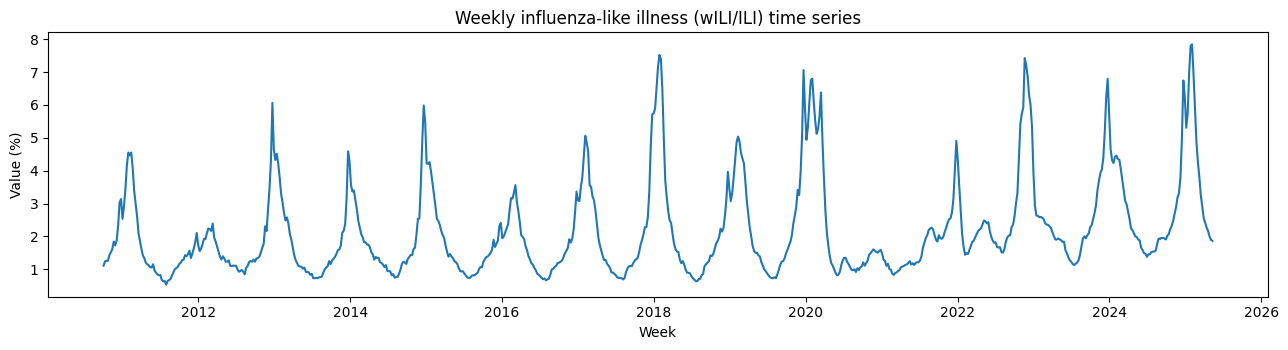

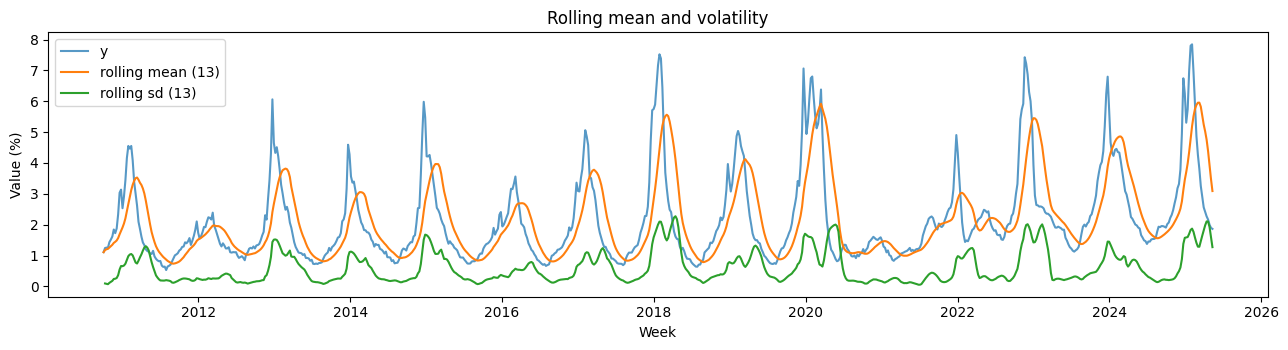

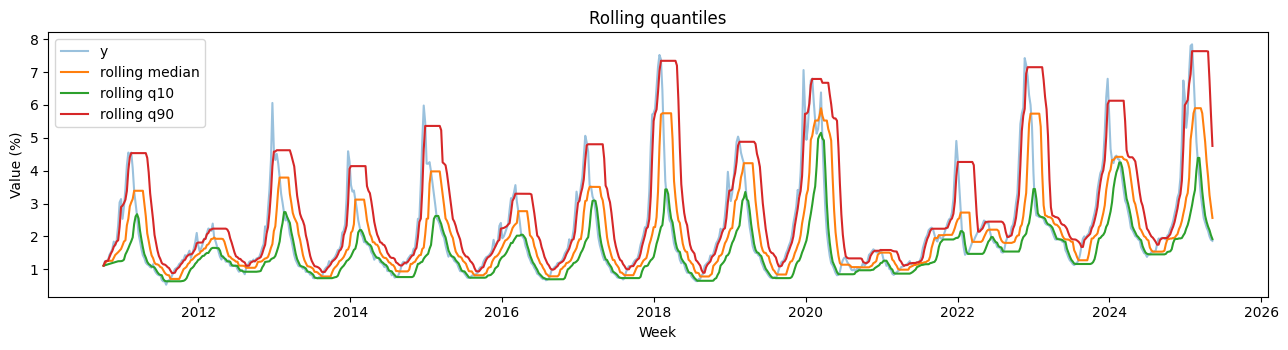

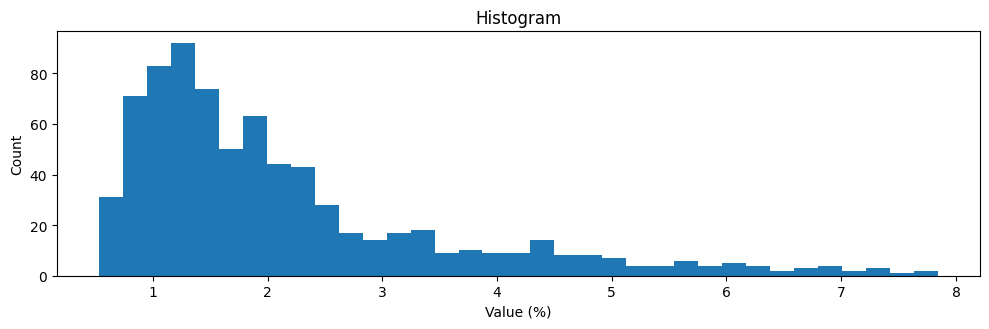

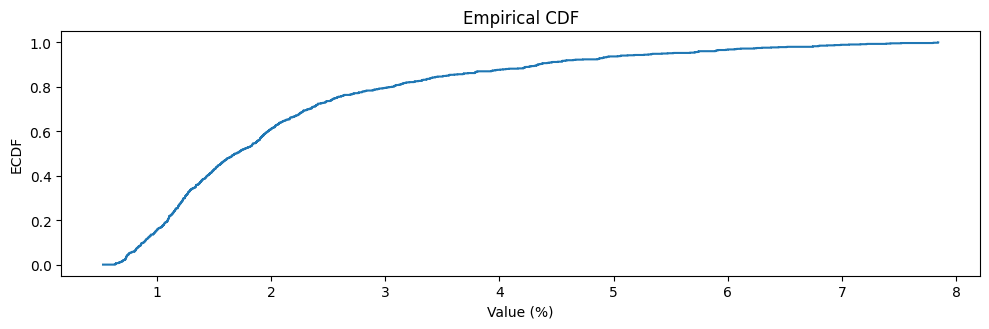

<Figure size 620x600 with 0 Axes>

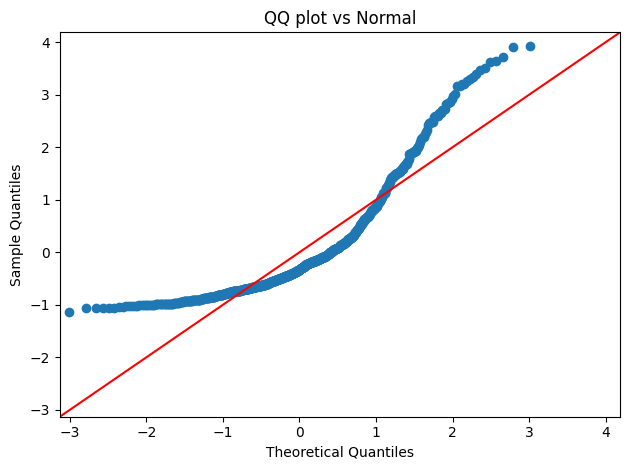

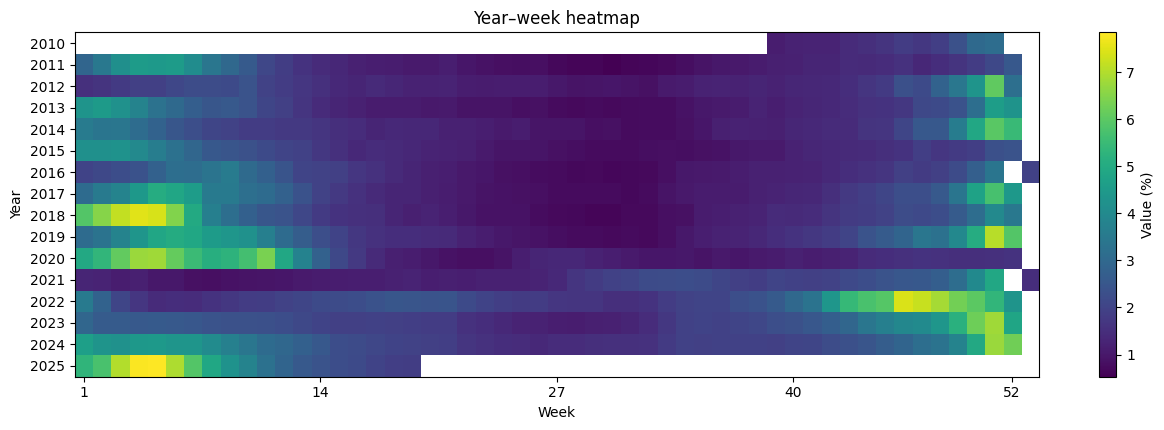

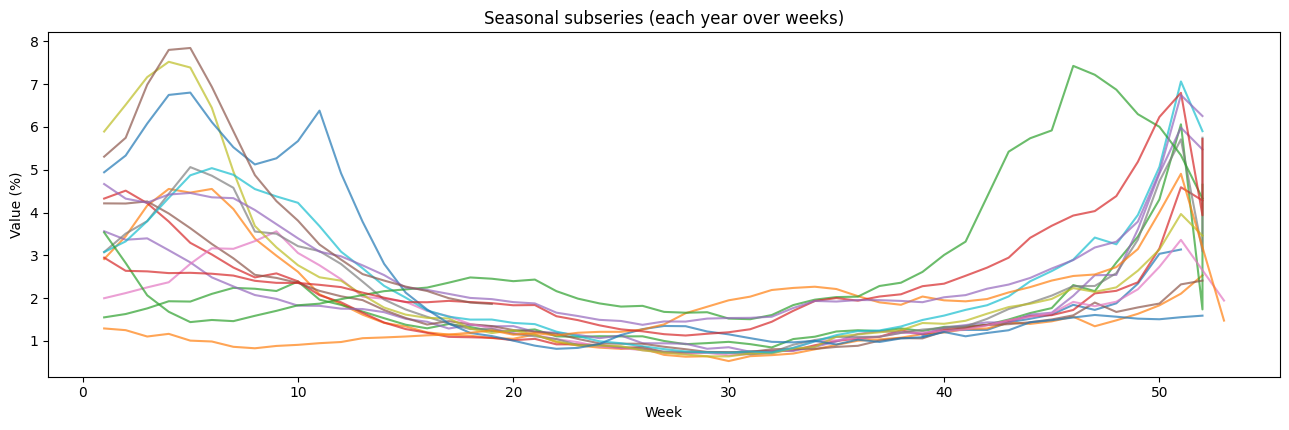

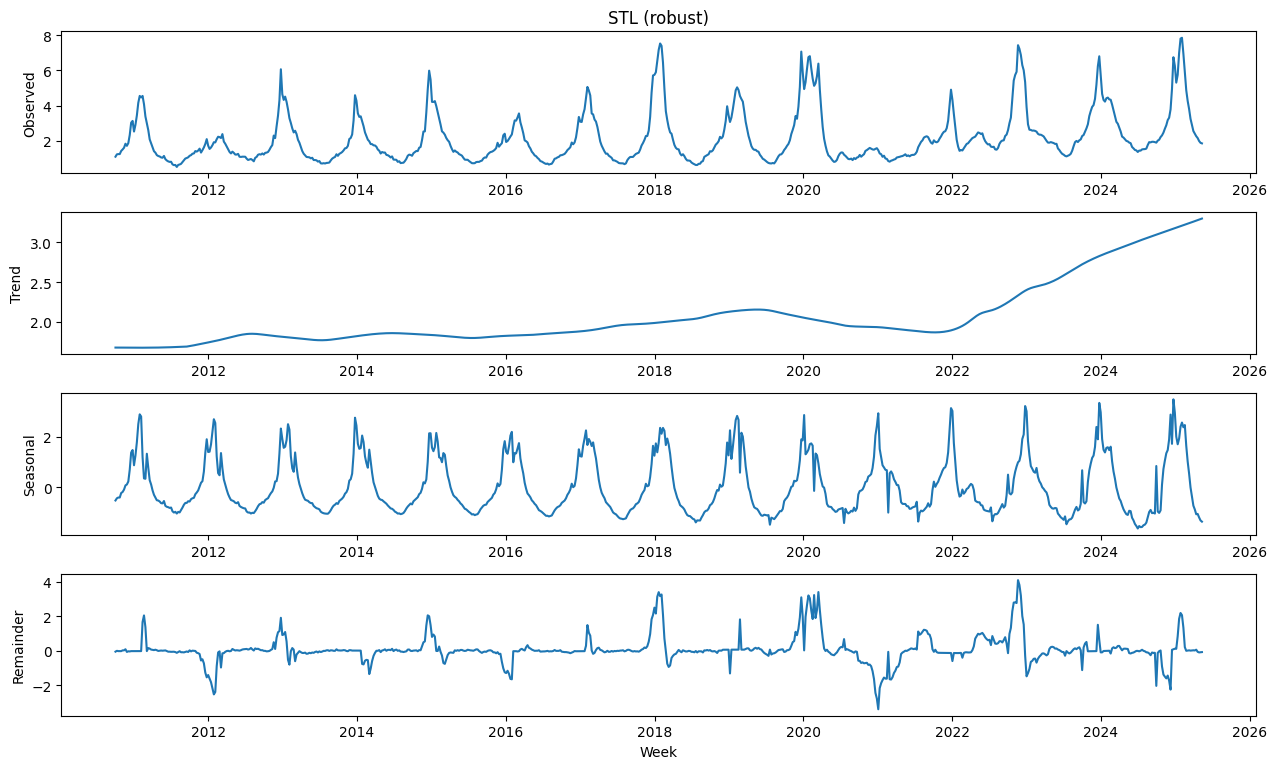

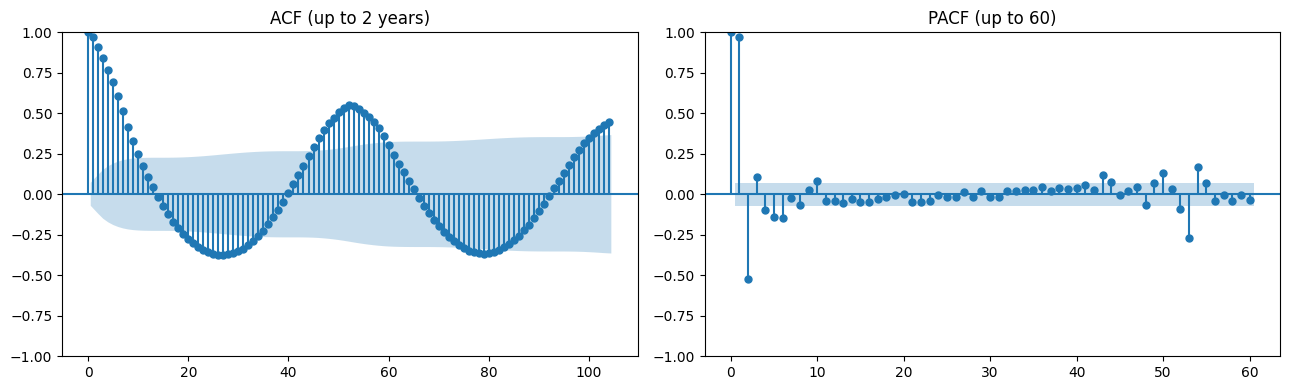

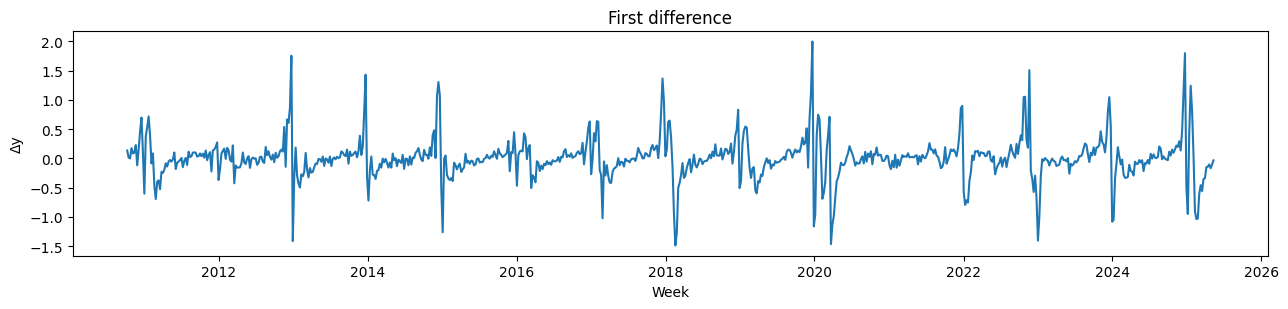

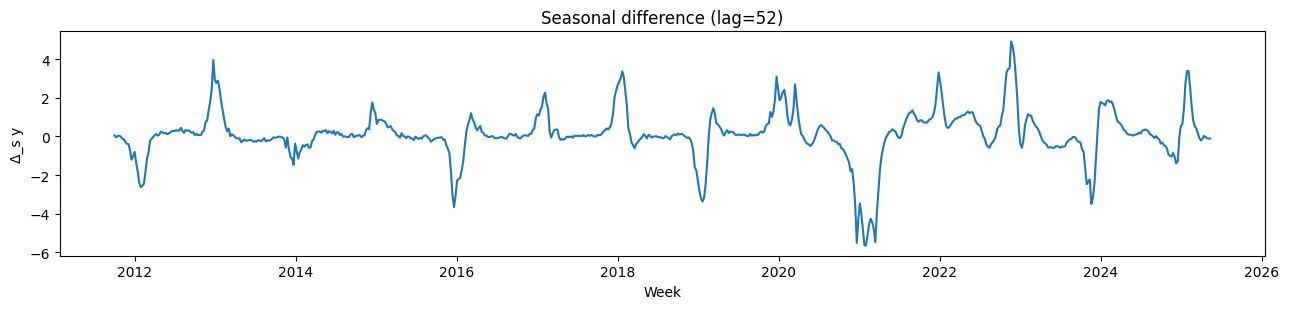

SARIMAX candidate fits:   0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



TABLE: SARIMAX candidate selection (top 25 by AIC)


,order,seasonal_order,AIC,BIC,HQIC,converged
0,"(2, 0, 1)","(0, 1, 1, 52)",100.906723,125.261463,110.525505,True
1,"(2, 0, 0)","(0, 1, 1, 52)",101.272493,121.579778,109.291995,True
2,"(2, 0, 2)","(0, 1, 1, 52)",102.870862,131.268350,114.087368,True
3,"(2, 0, 1)","(1, 1, 1, 52)",103.501632,131.915495,114.723544,True
4,"(2, 0, 0)","(1, 1, 1, 52)",105.315083,129.669822,114.933864,True
5,"(2, 0, 2)","(1, 1, 1, 52)",105.360699,137.814972,118.179563,True
6,"(2, 0, 1)","(1, 1, 0, 52)",109.717353,134.072092,119.336134,True
7,"(1, 0, 2)","(0, 1, 1, 52)",110.455957,134.796661,120.070104,False
8,"(2, 0, 2)","(1, 1, 0, 52)",111.600204,140.014066,122.822115,True
9,"(1, 0, 2)","(1, 1, 1, 52)",113.597436,141.994924,124.813941,True


        order seasonal_order         AIC         BIC        HQIC  converged
0   (2, 0, 1)  (0, 1, 1, 52)  100.906723  125.261463  110.525505       True
1   (2, 0, 0)  (0, 1, 1, 52)  101.272493  121.579778  109.291995       True
2   (2, 0, 2)  (0, 1, 1, 52)  102.870862  131.268350  114.087368       True
3   (2, 0, 1)  (1, 1, 1, 52)  103.501632  131.915495  114.723544       True
4   (2, 0, 0)  (1, 1, 1, 52)  105.315083  129.669822  114.933864       True
5   (2, 0, 2)  (1, 1, 1, 52)  105.360699  137.814972  118.179563       True
6   (2, 0, 1)  (1, 1, 0, 52)  109.717353  134.072092  119.336134       True
7   (1, 0, 2)  (0, 1, 1, 52)  110.455957  134.796661  120.070104      False
8   (2, 0, 2)  (1, 1, 0, 52)  111.600204  140.014066  122.822115       True
9   (1, 0, 2)  (1, 1, 1, 52)  113.597436  141.994924  124.813941       True
10  (2, 0, 0)  (1, 1, 0, 52)  114.175228  134.470844  122.190879       True
11  (1, 1, 0)  (0, 1, 1, 52)  117.672606  133.909099  124.085127       True
12  (2, 1, 0

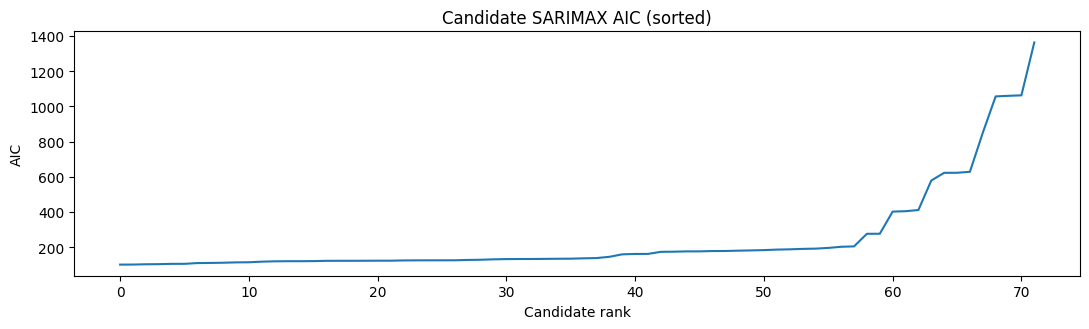

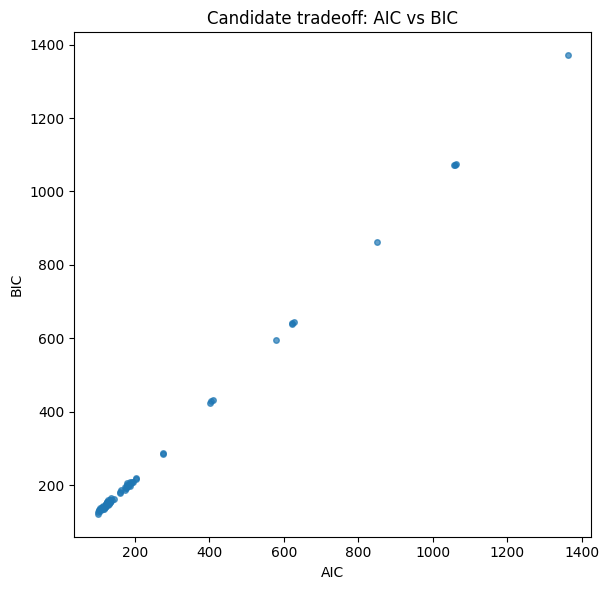


TABLE: SARIMAX parameter estimates (train fit)


,coef,se,z,p_value
intercept,0.003780,0.006998,0.540180,5.890728e-01
ar.L1,1.543407,0.090011,17.146905,0.000000e+00
ar.L2,-0.607890,0.087344,-6.959706,3.409939e-12
ma.L1,-0.207055,0.104235,-1.986434,4.698518e-02
ma.S.L52,-0.493837,0.027293,-18.094136,0.000000e+00
sigma2,0.071530,0.002282,31.339627,0.000000e+00


               coef        se          z       p_value
intercept  0.003780  0.006998   0.540180  5.890728e-01
ar.L1      1.543407  0.090011  17.146905  0.000000e+00
ar.L2     -0.607890  0.087344  -6.959706  3.409939e-12
ma.L1     -0.207055  0.104235  -1.986434  4.698518e-02
ma.S.L52  -0.493837  0.027293 -18.094136  0.000000e+00
sigma2     0.071530  0.002282  31.339627  0.000000e+00


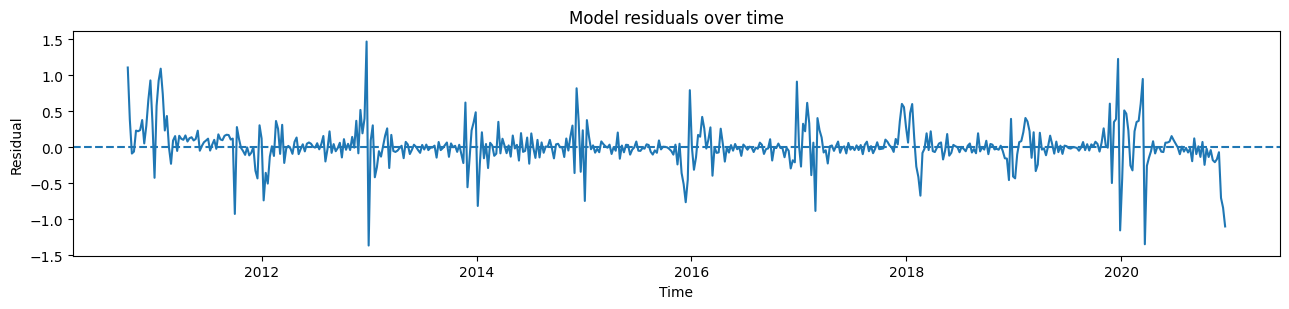

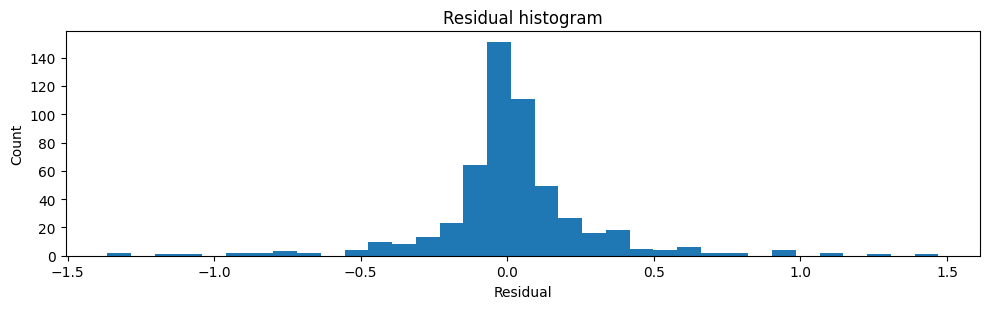

<Figure size 620x600 with 0 Axes>

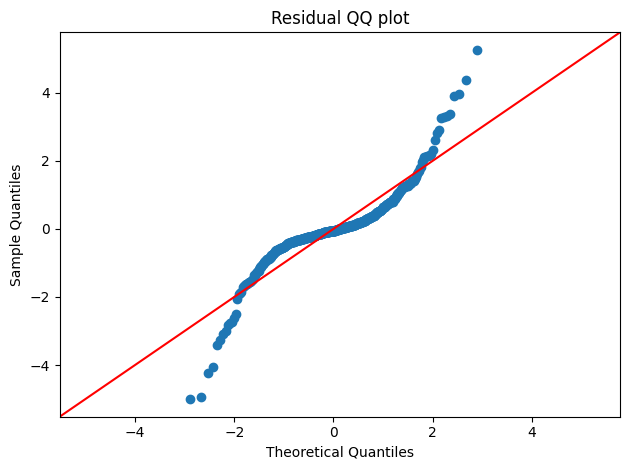

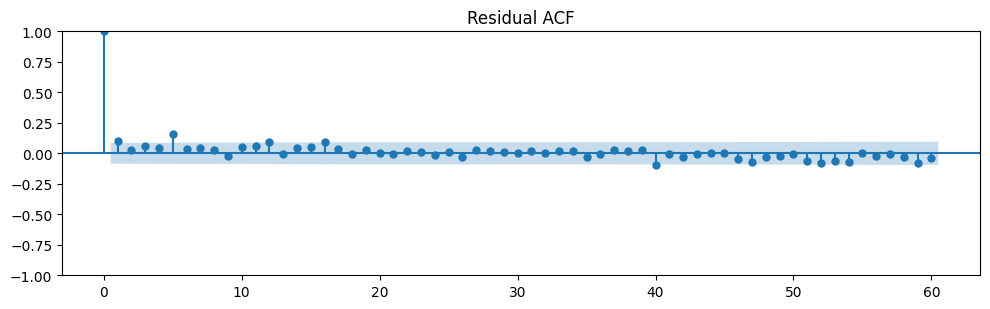


TABLE: Residual diagnostics tests (JB, Ljung-Box)


,JarqueBera_stat,JarqueBera_p,LjungBox_p_lag10,LjungBox_p_lag20,LjungBox_p_lag30
tests,1051.311557,5.135656e-229,0.003553,0.004489,0.069629


       JarqueBera_stat   JarqueBera_p  LjungBox_p_lag10  LjungBox_p_lag20  LjungBox_p_lag30
tests      1051.311557  5.135656e-229          0.003553          0.004489          0.069629


Rolling-origin evaluation:   0%|          | 0/221 [00:00<?, ?it/s]

In [ ]:
%run companion_epitime_pipeline.py \
  --ew_start 201040 --ew_end 202520 \
  --geo nat --signal wili \
  --grid paper --train_frac 0.70 --refit_every 13 \
  --alpha 0.05 --maxiter 200 \
  --outdir outputs --download_zip

# If you didn't pass --download_zip (or want again):
from google.colab import files
files.download(LAST_ZIP_PATH)
